### Notebook för att utforska vilken modell som är bäst att använda för att prediktera taxipriser

För att i det riktiga programmet använda en väl lämpad modell behöver jag först utvärdera olika alternativ och se hur bra de presterar på min data.   

Jag gör dessa tester i en notebook för att på ett enkelt sätt kunna testa flera modeller och jämföra deras resultat.   

Eftersom uppgiften gäller att prediktera ett kontinuerligt värde (pris) är linjär regression en naturlig kandidat. Samtidigt kan jag testa andra modeller, som t.ex. Random Forest Regression, för att se om de eventuellt ger bättre resultat på datan. Logistisk regression är däremot inte lika relevant här eftersom den främst används för klassificeringsproblem (t.ex. ja/nej-frågor).   

In [24]:
from taxipred.utils.constants import DATA_PATH
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../src/taxipred/data/cleaned_taxi_trip_pricing.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       778 non-null    float64
 1   Time_of_Day            778 non-null    object 
 2   Day_of_Week            778 non-null    object 
 3   Passenger_Count        778 non-null    float64
 4   Traffic_Conditions     778 non-null    object 
 5   Weather                778 non-null    object 
 6   Base_Fare              778 non-null    float64
 7   Per_Km_Rate            778 non-null    float64
 8   Per_Minute_Rate        778 non-null    float64
 9   Trip_Duration_Minutes  778 non-null    float64
 10  Trip_Price             778 non-null    float64
dtypes: float64(7), object(4)
memory usage: 67.0+ KB


In [25]:
df["Base_Fare"].describe()

count    778.000000
mean       3.501183
std        0.862779
min        2.010000
25%        2.730000
50%        3.535000
75%        4.230000
max        5.000000
Name: Base_Fare, dtype: float64

##### Delar upp datan i train | test

In [26]:
X = df.drop(columns=["Trip_Price"]) #tar bort alla kolumner förutom den som ska vara y.
y = df["Trip_Price"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((544, 10), (234, 10), (544,), (234,))

##### Eftersom mitt dataset innehåller både numeriska och kategoriska kolumner behöver jag särskilja dessa och hantera dem på olika sätt.   
StandardScaler gör att features får medelvärde 0 och standardavvikelse 1.   
OneHotEncoder gör så att modellerna kan hantera textvaiabler. 


In [28]:
# 1) Dela upp kolumner
num_cols = X_train.select_dtypes(include="number").columns
cat_cols = X_train.select_dtypes(exclude="number").columns
#

# Skala numeriska
scaler = StandardScaler()
scaled_X_train_num = scaler.fit_transform(X_train[num_cols])
scaled_X_test_num  = scaler.transform(X_test[num_cols])


# 3) One-hot-koda kategoriska
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat  = encoder.transform(X_test[cat_cols])


# 4) Slå ihop till en enda feature-matris
import numpy as np
X_train_prepared = np.hstack([scaled_X_train_num, X_train_cat])
X_test_prepared  = np.hstack([scaled_X_test_num, X_test_cat])


In [29]:
model = LinearRegression()
model.fit(X_train_prepared, y_train)
y_pred_lr = model.predict(X_test_prepared)

In [ ]:
model.coef_

array([36.66371503,  0.36679852,  1.51516123, 10.59317153,  6.59979555,
       10.21894227,  0.43257082, -1.03345688, -0.12066615,  0.7215522 ,
        0.43849313, -0.369581  , -0.06891213,  1.15454986, -2.19191935,
       -0.83454461,  1.8719141 , -0.15008829, -0.83710837,  1.80041804,
       -0.81322138])

### Prediktion

In [30]:
test_sample_features = X_test_prepared[0].reshape(1, -1)
test_sample_target = y_test.values[0]

print("Test sample features: ", test_sample_features)
print("Test sample target: ", test_sample_target)

Test sample features:  [[ 0.84611398 -1.40147905  1.15924198  0.83001055  0.48902436  1.04244211
   0.          0.          1.          0.          0.          0.
   1.          0.          1.          0.          0.          1.
   0.          0.          0.        ]]
Test sample target:  108.2325


In [31]:
model.predict(test_sample_features)

array([110.17021529])

In [32]:
test_sample_target

np.float64(108.2325)

##### Prediktion av testdatan

In [33]:
y_pred_lr = model.predict(X_test_prepared)
y_pred_lr.shape

(234,)

In [34]:
y_pred_lr[:5]


array([110.17021529,  77.39803316,  26.47614327,  51.99699327,
       100.66154628])

In [35]:
y_test[:5].values

array([108.2325,  73.5544,  32.2622,  38.4514, 102.4302])

### Evaluering

In [36]:

print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("MAE: ", mean_absolute_error(y_test, y_pred_lr))
print("RMSE: ", root_mean_squared_error(y_test, y_pred_lr))
print("R2 :", r2_score(y_test, y_pred_lr))

MSE: 226.81751579226025
MAE:  9.505027649510083
RMSE:  15.060462004608631
R2 : 0.8463709689648986


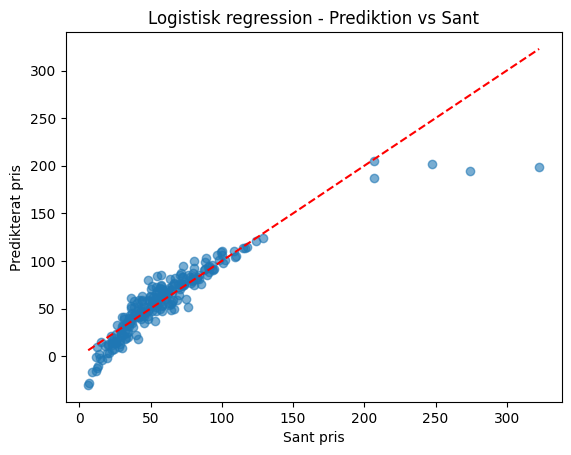

In [37]:

plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Sant pris")
plt.ylabel("Predikterat pris")
plt.title("Logistisk regression - Prediktion vs Sant")
plt.show()

### Testa datan med Random Forest Regression
Eftersom vi i skolan inte gått igenom Random Forest Regeression i kod, utan enbart Random Forest Classifier, och det inte är en fungerande metod för detta dataset, har jag använt mig av följande youtube-film för att förstå och kunna använda Random Forest Regression: https://www.youtube.com/watch?v=VQT1PU3-wqE

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    oob_score=True,      
    max_samples=60      
)

rf = model.fit(X_train_prepared, y_train)
y_pred_rf = rf.predict(X_test_prepared)

In [40]:
rf.oob_score_

0.881942969400153

In [ ]:
rf.feature_importances_
rf.feature_names_in_ # Genererar felmedelande pga min version av scikit-learn. 

AttributeError: 'RandomForestRegressor' object has no attribute 'feature_names_in_'

In [41]:
#För att se feature names i feature_importances behöver jag spara en lista med alla feature_names i en variabel, och använda listan för importances. 

num_feature_names = num_cols  
cat_feature_names = encoder.get_feature_names_out(cat_cols) 
all_feature_names = list(num_feature_names) + list(cat_feature_names)

In [42]:
importances = pd.Series(rf.feature_importances_, index=all_feature_names)

In [43]:
importances_sorted = importances.sort_values(ascending=False)

print(importances_sorted.head(10))

Trip_Distance_km          0.766463
Per_Km_Rate               0.089224
Trip_Duration_Minutes     0.064717
Per_Minute_Rate           0.043975
Base_Fare                 0.012401
Passenger_Count           0.004839
Day_of_Week_Weekday       0.002389
Traffic_Conditions_Low    0.001830
Weather_Clear             0.001589
Weather_Rain              0.001528
dtype: float64


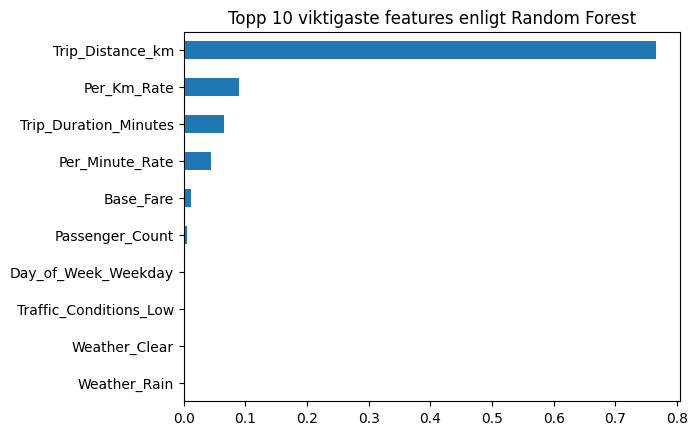

In [44]:
importances_sorted.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Topp 10 viktigaste features enligt Random Forest")
plt.show()

Utvärdering av modellen

In [45]:
print(y_pred_rf[:5]) 
print(y_test[:5].values)

[90.717556 69.698806 37.32531  50.55564  87.322374]
[108.2325  73.5544  32.2622  38.4514 102.4302]


In [46]:
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
r2  = r2_score(y_test, y_pred_rf)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)

MAE: 8.155454022479091
MSE: 137.00605872959227
R²: 0.9072024575569234


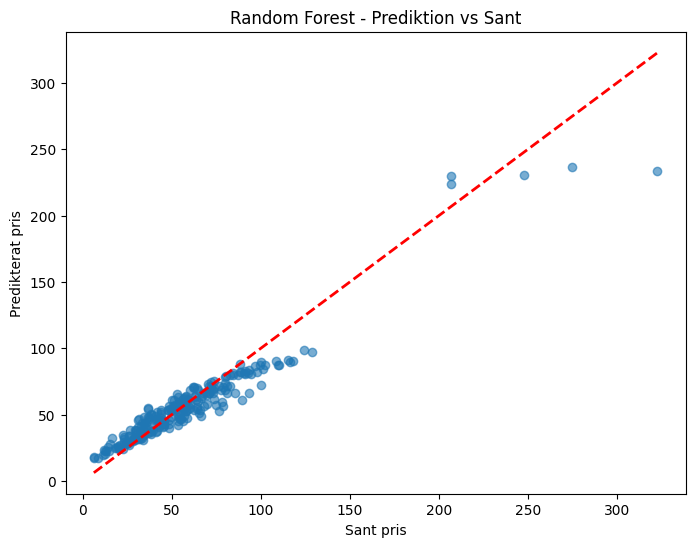

In [47]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2) 

plt.xlabel("Sant pris")
plt.ylabel("Predikterat pris")
plt.title("Random Forest - Prediktion vs Sant")
plt.show()

### Testa datan med KNN (Know Nearest Neighbour)
Jag tror egentligen inte att KNN är den bästa modellen för den här typen av prediktion, men jag väljer ändå att testa även KNN för att öva mer på olika modeller, och jämföra resultatet med Linjär Regression och Random Forest Regression. 

In [48]:
from sklearn.neighbors import KNeighborsRegressor

model_KNN = KNeighborsRegressor(n_neighbors=5) 

In [49]:
model_KNN.fit(X_train_prepared, y_train)

y_pred_KNN = model_KNN.predict(X_test_prepared)
y_pred_KNN[:5]

array([75.27102, 63.01172, 39.30472, 49.90852, 94.63904])

In [ ]:
y_test[:5].values

array([108.2325,  73.5544,  32.2622,  38.4514, 102.4302])

In [50]:
mae = mean_absolute_error(y_test, y_pred_KNN)
mse = mean_squared_error(y_test, y_pred_KNN)
r2  = r2_score(y_test, y_pred_KNN)

print("MAE:", mae)
print("MSE:", mse)
print("R²:", r2)

MAE: 11.616785647083601
MSE: 256.5461980735895
R²: 0.8262350079617191


### Sammanfattning och jämförelse av Linjär regression, Random Forest Regression och KNN Regression


In [51]:
def summarize_models(y_true, preds):
    rows = []
    for name, y_pred in preds.items():
        mae  = mean_absolute_error(y_true, y_pred)
        mse  = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2   = r2_score(y_true, y_pred)
        rows.append({"model": name, "MAE": mae, "RMSE": rmse, "R2": r2})
    return pd.DataFrame(rows).sort_values(by="MAE")

results = summarize_models(
    y_test,
    {"Linear Regression": y_pred_lr,
     "Random Forest Regression": y_pred_rf,
     "KNN (k=5)": y_pred_KNN}
)

results

,model,MAE,RMSE,R2
1,Random Forest Regression,8.155454,11.704959,0.907202
0,Linear Regression,9.505028,15.060462,0.846371
2,KNN (k=5),11.616786,16.017060,0.826235
